In [14]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import csv
import random
import os
from functools import partial

In [15]:
from paths import CAR_IMAGES_DIR  # YOU NEED TO GO TO THE paths.py FILE AND PUT YOUR FOLDER OF IMAGES

In [16]:
INDIVIDUAL_IMG_PATHS = [CAR_IMAGES_DIR / image_name for image_name in os.listdir(CAR_IMAGES_DIR)]

In [17]:
print(INDIVIDUAL_IMG_PATHS[23])

/home/adrian/Documents/academia/UAB/year_3/vision_learning/project1/archive/images/Cars329.png


In [19]:
def binary_methods(image_path, method = 'simple'):
    image_org = cv.imread(str(image_path))

    # Convert the image from BGR to RGB
    image_rgb = cv.cvtColor(image_org, cv.COLOR_BGR2RGB)
    image_gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)

    blur = cv.GaussianBlur(image_gray, (5, 5), 0)

    if method == 'original':
        return image_rgb
    
    if method == 'simple':
        binary__image = cv.threshold(blur, 127, 255, 0)[1]

    elif method == 'adaptive':
        binary__image = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)

    elif method == 'otsu':
        _, binary__image = cv.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

    elif method == 'Gaus_otsu':
        _, binary__image = cv.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

    return binary__image

In [21]:
def plot_car():
    plt.figure(figsize=(15, 10))   # (width, height)
    methods = ['original', 'simple', 'adaptive', 'otsu', 'Gaus_otsu']
    
    for i in range(len(methods) * 3):
        pos = i % len(methods)
        if (pos == 0):
            image_path = random.choice(INDIVIDUAL_IMG_PATHS)
            
        image = binary_methods(image_path, method=methods[pos])
        plt.subplot(3, len(methods), i+1)
        plt.imshow(image, 'gray')
        plt.title(methods[pos])
        plt.xticks([]),plt.yticks([])
    
    plt.show()

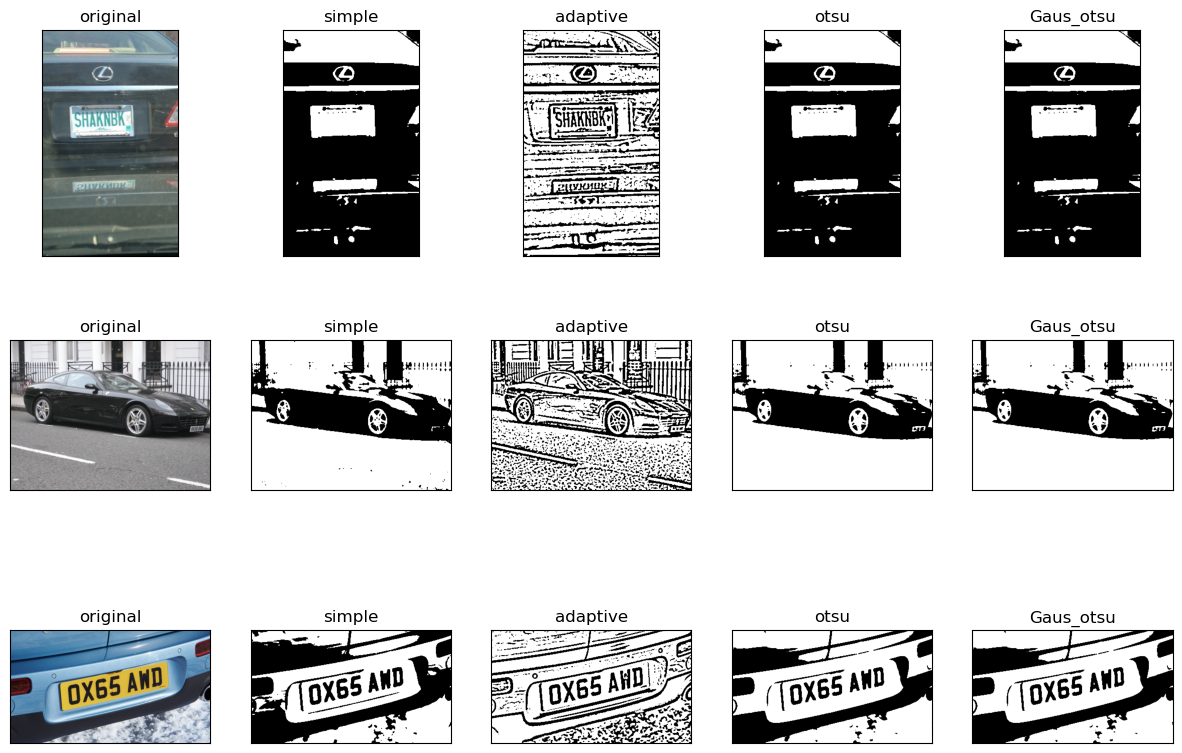

In [22]:
plot_car()

In [24]:
def mhorp_operations():
    pass

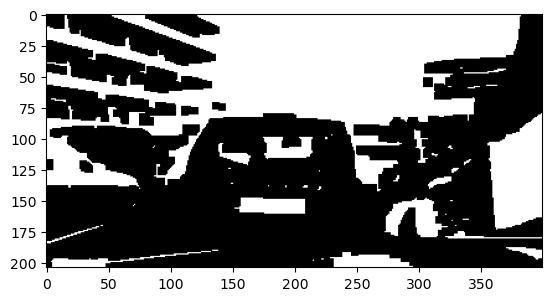

In [25]:
kernel = np.ones((6,6), np.uint8)  # 5x5 rectangular structuring element

image = cv.imread(str(INDIVIDUAL_IMG_PATHS[25]))

    # Convert the image from BGR to RGB
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image_gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)
binary_image = cv.threshold(image_gray, 127, 255, 0)[1]

dilated_image = cv.morphologyEx(binary_image, cv.MORPH_CLOSE, kernel)

plt.imshow(dilated_image, "gray")

In [26]:
canny = cv.Canny(dilated_image, 120, 255, 1)

# Find contours
cnts = cv.findContours(canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

crop_crd = dict()

# Iterate thorugh contours and draw rectangles around contours
for c in cnts:
    x,y,w,h = cv.boundingRect(c)
    cv.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
    crop_crd[c.tostring()] = (x, y, w, h)

"""
cv.imshow('canny', canny)
cv.imshow('image', image)
cv.imwrite('canny.png', canny)
cv.imwrite('image.png', image)
cv.waitKey(0)
"""

/tmp/ipykernel_92611/1530192145.py:13: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  crop_crd[c.tostring()] = (x, y, w, h)


"\ncv.imshow('canny', canny)\ncv.imshow('image', image)\ncv.imwrite('canny.png', canny)\ncv.imwrite('image.png', image)\ncv.waitKey(0)\n"

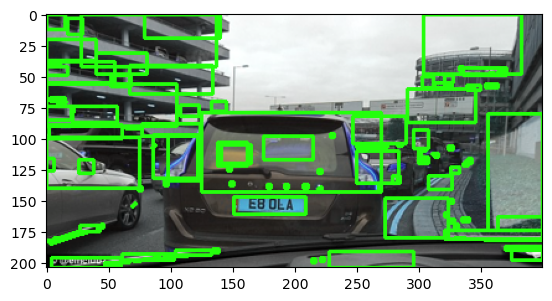

In [27]:
plt.imshow(image)

In [34]:
# Initialize an all-black image (mask)
#mask = np.zeros_like(image)

image_org = cv.imread(str(INDIVIDUAL_IMG_PATHS[25]))

with open("image_annotations.csv", "w") as file:
    pass

dataset_annotations = list()

image_crops = list()

image_crops.append("Image1.png")

# Iterate through contours and draw filled rectangles on the mask
for c in cnts:

    crop = list()

    x, y, w, h = cv.boundingRect(c)
    crop.append(x)
    crop.append(y)
    crop.append(w)
    crop.append(h)

    # Draw the rectangle on the image
    #cv.rectangle(image, (x, y), (x + w, y + h), (255, 255, 255), -1) 

    # Crop the image using the coordinates x, y, w, and h
    cropped_image = image_org[y:y+h, x:x+w]

    # Display the cropped image
    cv.imshow('Cropped Image', cropped_image)
    cv.waitKey(0)
    cv.destroyAllWindows()

    license_bool = int(input("(0 or 1) License? "))
    crop.append(license_bool)

    image_crops.append(crop)

with open("image_annotations.csv", "w", newline="") as file:

    writer = csv.writer(file)
    writer.writerow(image_crops)



In [35]:
print(image_crops)

['Image1.png', [51, 200, 9, 1, 0], [47, 200, 3, 4, 0], [62, 199, 5, 1, 0], [70, 198, 6, 1, 0], [214, 197, 3, 3, 0], [78, 197, 6, 1, 0], [221, 196, 3, 3, 0], [86, 196, 6, 1, 0], [4, 196, 56, 8, 0], [95, 195, 8, 1, 0], [105, 194, 9, 1, 0], [61, 193, 42, 5, 0], [228, 191, 68, 13, 0], [375, 190, 25, 8, 0], [104, 190, 29, 4, 0], [134, 189, 5, 3, 0], [370, 187, 30, 3, 0], [3, 184, 2, 1, 0], [7, 183, 1, 1, 0], [9, 182, 2, 1, 0], [0, 182, 5, 1, 0], [353, 181, 47, 1, 0], [13, 181, 1, 1, 0], [329, 180, 9, 1, 0], [16, 180, 1, 1, 0], [6, 180, 5, 2, 0], [19, 179, 1, 1, 0], [12, 179, 2, 1, 0], [22, 178, 1, 1, 0], [15, 178, 2, 1, 0], [25, 177, 1, 1, 0], [18, 177, 2, 1, 0], [28, 176, 2, 1, 0], [21, 176, 2, 1, 0], [31, 175, 2, 1, 0], [24, 175, 2, 1, 0], [321, 174, 79, 7, 0], [41, 172, 2, 1, 0], [44, 171, 2, 1, 0], [27, 170, 16, 5, 0], [329, 169, 3, 3, 0], [44, 169, 2, 1, 0], [326, 165, 3, 3, 0], [335, 164, 6, 3, 0], [364, 163, 36, 11, 0], [321, 160, 3, 3, 0], [69, 154, 1, 1, 0], [71, 152, 1, 1, 0], [32